In [17]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import matplotlib.pyplot as plt
from random import shuffle

In [18]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 1
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [19]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6, 6])
    elif(n == 2):
        a = np.array([[-6, 15], [-6, -15], [8, 0]])
    elif(n == 3):
        a = np.array([[-6, 15,-10], [-6, -15,-10], [8, 0, -10], [0, 0, 10]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [20]:
# Function to solve for a specific block, given a beta
def solveXYBlock(Y, y_points, anchors, adjacency, n, npoints, beta):
    off = n + 1
    
    xlist = []
    for j in range(npoints):
        xlist.append(cvx.Variable(n))
        
    objfunc = 0 * cvx.Variable(1)
    constr  = 0 * cvx.Variable(n)
    
    for j in range(off,off+npoints):
        
        # Add the anchor constraints
        x_j = xlist[j-off]
        for k in range(off):
            if(adjacency[k,j] > 0.):
                objfunc += ((anchors[k]-x_j).T*(anchors[k]-y_points[j-off]) - adjacency[k,j]**2)**2
                
        # Add the point to point constraints
        for i in range(off,off+npoints):
            if(adjacency[i,j] > 0.):
                #d_ij
                x_i = xlist[i-off]
                objfunc += ((x_i - x_j).T * (y_points[i-off]-y_points[j-off]) - adjacency[i,j]**2)**2

        # Constraints
        constr += x_j - y_points[j-off]
        
    # Construct the problem
    objective = cvx.Minimize(objfunc \
                             - cvx.sum_entries(cvx.mul_elemwise(Y,constr)) \
                             + (beta / 2.) * cvx.norm(constr,2)**2)
    p = cvx.Problem(objective)

    # Solve
    result = p.solve()
    
    x = [xlist[i].value.A.flatten() for i in range(npoints)]
    
    return x

In [45]:
n = 3
npoints = 2
[a,p,adjacency]=generate_inside_hull(n,npoints)

3
3


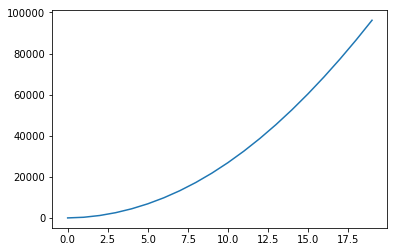

In [47]:
beta  = 0.1
niter = 100

Y = np.random.rand(n)

y_points = []
x_points = []
for j in range(npoints):
    y_points.append(np.random.rand(n))
    x_points.append(np.random.rand(n))

res = np.zeros(int(niter/5))

for it in range(niter):
    x_points = solveXYBlock(Y,y_points,a, adjacency,n,npoints,beta)
    y_points = solveXYBlock(Y,x_points,a, adjacency,n,npoints,beta)
    for j in range(npoints):
        Y -= beta*(x_points[j] - y_points[j])
    if(it % 5 == 0):
        res[int(it/5)] = np.dot(Y,Y)

plt.plot(range(res.size),res)
plt.show()

In [43]:
x_points

[array([-381.97843984, -355.58372328, -151.90174201]),
 array([ 31.70019156,  29.87898426,  20.67677049]),
 array([ 416.61263548,  144.60497334,  -11.73125744])]

In [35]:
p

array([[ 3.14097355, -1.70760106,  3.1445877 ],
       [ 4.15952526,  1.9147412 ,  0.37414534],
       [ 3.42196276, -3.3375846 ,  2.92863714]])